In [2]:
import os

import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr

from jaxparrow.tools import compute_coriolis_factor, compute_spatial_step, compute_cyclogeostrophic_diff_jax
from jaxparrow import cyclogeostrophy, geostrophy

%reload_ext autoreload
%autoreload 2

# Reading data

## Parameters

In [3]:
dir_data = "data"
name_mask = "mask_eNATL60MEDWEST_3.6.nc"
name_coord = "coordinates_eNATL60MEDWEST.nc"
name_ssh = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc"
name_u = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc"
name_v = "eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc"

## Opening data

In [4]:
ds_coord = xr.open_dataset(os.path.join(dir_data, name_coord))
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(os.path.join(dir_data, name_mask))
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(os.path.join(dir_data, name_ssh))
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(os.path.join(dir_data, name_u))
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(os.path.join(dir_data, name_v))
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

In [5]:
mask_u = 1 - mask_u
mask_v = 1 - mask_v
mask_ssh = 1- mask_ssh

In [6]:
uvel = ma.masked_array(uvel, mask_u)
vvel = ma.masked_array(vvel, mask_v)
ssh = ma.masked_array(ssh, mask_ssh)

In [7]:
lon_u = ma.masked_array(lon_u, mask_u)
lat_u = ma.masked_array(lat_u, mask_u)
lon_v = ma.masked_array(lon_v, mask_v)
lat_v = ma.masked_array(lat_v, mask_v)
lon_ssh = ma.masked_array(lon_ssh, mask_ssh)
lat_ssh = ma.masked_array(lat_ssh, mask_ssh)

## Ploting the data

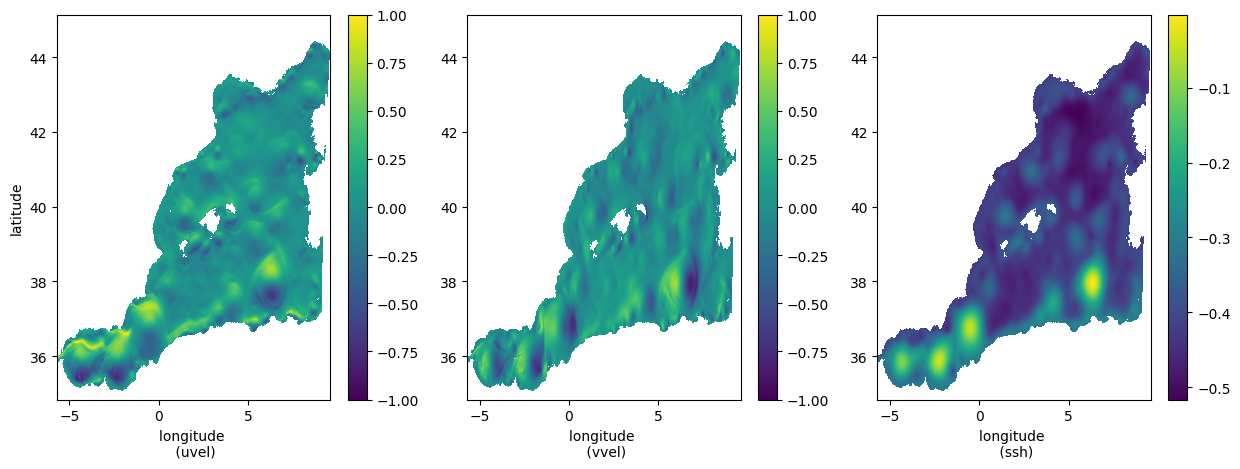

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (vvel)")
ax3.set_xlabel("longitude \n (ssh)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, vvel, shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, ssh, shading="auto")
plt.colorbar(im, ax=ax3)
plt.show()

## Create arrays of spatial steps

These dx and dy steps must be used to compute derivatives.

In [9]:
dx_ssh, dy_ssh = compute_spatial_step(lat_ssh, lon_ssh)
dx_u, dy_u = compute_spatial_step(lat_u, lon_u)
dx_v, dy_v = compute_spatial_step(lat_v, lon_v)

# Input data

In [10]:
coriolis_factor_ssh = compute_coriolis_factor(lat_ssh)
coriolis_factor_u = compute_coriolis_factor(lat_u)
coriolis_factor_v = compute_coriolis_factor(lat_v)

# Geostrophic balance

In [11]:
u_geos, v_geos = geostrophy(ssh, dx_ssh, dy_ssh, coriolis_factor_u, coriolis_factor_v)

In [12]:
u_geos = ma.masked_array(u_geos, mask_u)
v_geos = ma.masked_array(v_geos, mask_v)

## Plotting the u_geos and v_geos

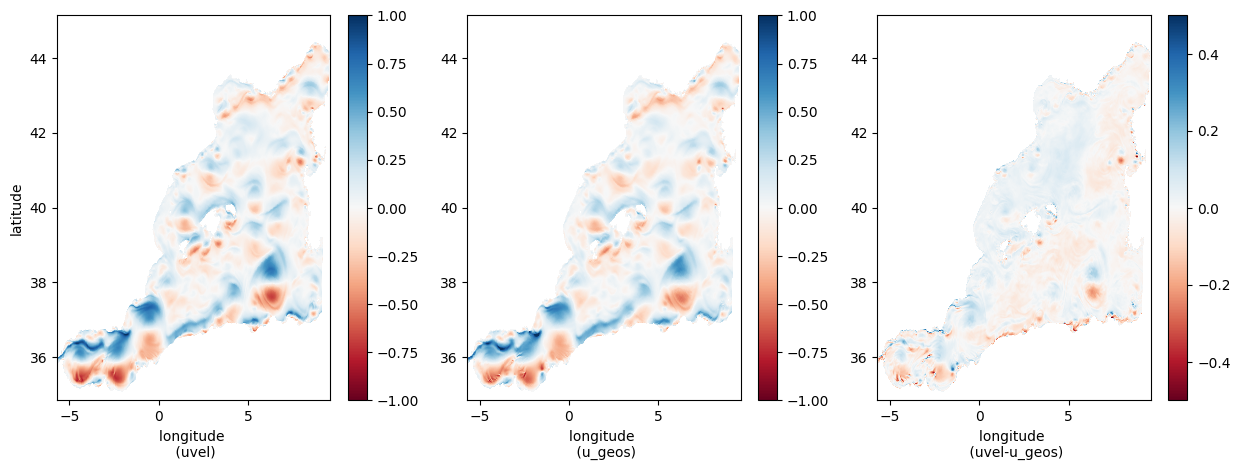

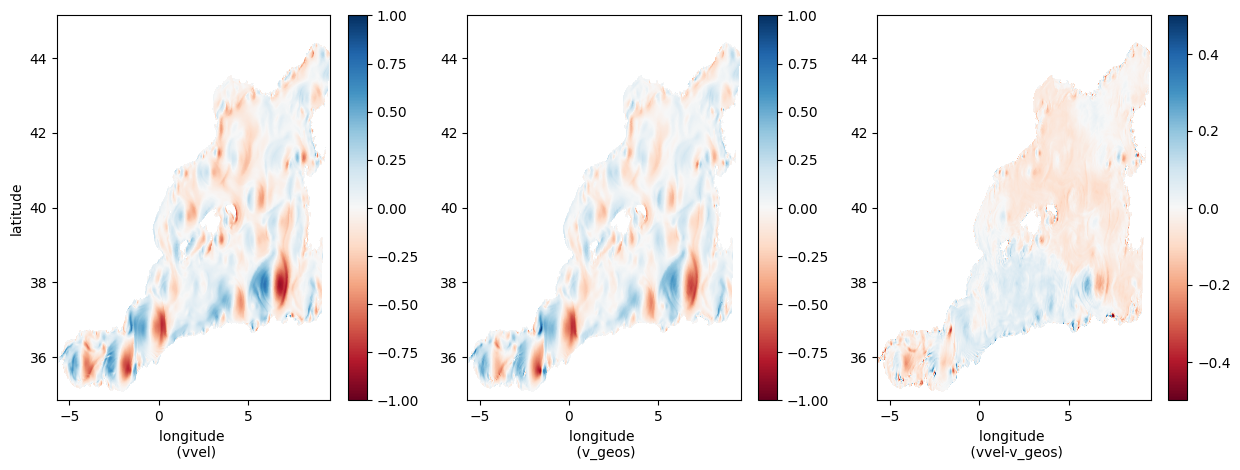

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_geos)")
ax3.set_xlabel("longitude \n (uvel-u_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_geos, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, uvel - u_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_geos)")
ax3.set_xlabel("longitude \n (vvel-v_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_geos, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, vvel-v_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

# Cyclogeostrophic balance

## Defining the cost function

In [14]:
# Initial loss
compute_cyclogeostrophic_diff_jax(u_geos.filled(0), v_geos.filled(0), u_geos.filled(0), v_geos.filled(0), dx_u, dx_v, dy_u, dy_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1))

2023-10-19 18:14:48.961827: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(1001.07965, dtype=float32)

## Computing the cyclogeostrophy - Minimization method

In [15]:
# run gradient descent to minimize f
u_min, v_min = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v)

100%|██████████| 2000/2000 [01:44<00:00, 19.22it/s]


In [16]:
compute_cyclogeostrophic_diff_jax(u_geos.filled(0), v_geos.filled(0), u_min, v_min, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1))

Array(7.036831, dtype=float32)

In [17]:
u_min = ma.masked_array(u_min, mask_u)
v_min = ma.masked_array(v_min, mask_v)

## Plotting u_min v_min

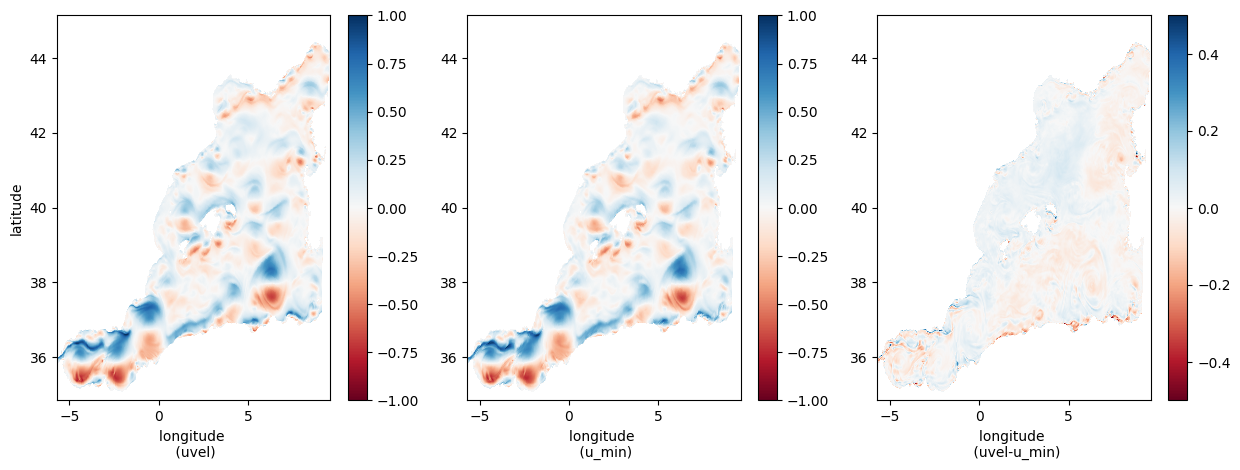

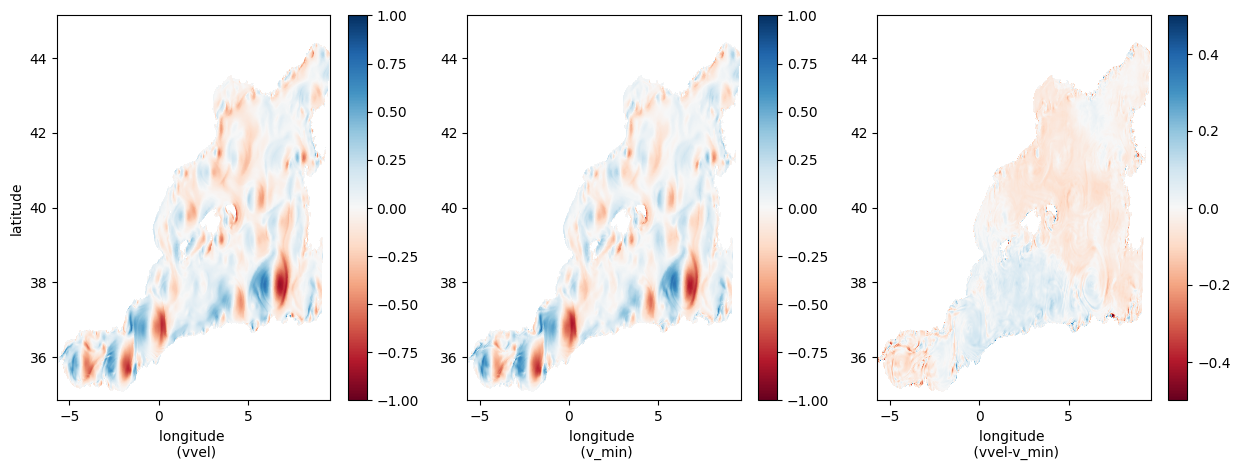

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_min)")
ax3.set_xlabel("longitude \n (uvel-u_min)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_min, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, uvel-u_min, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_min)")
ax3.set_xlabel("longitude \n (vvel-v_min)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_min, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, vvel-v_min, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

## Plotting differences with the geostrophic method

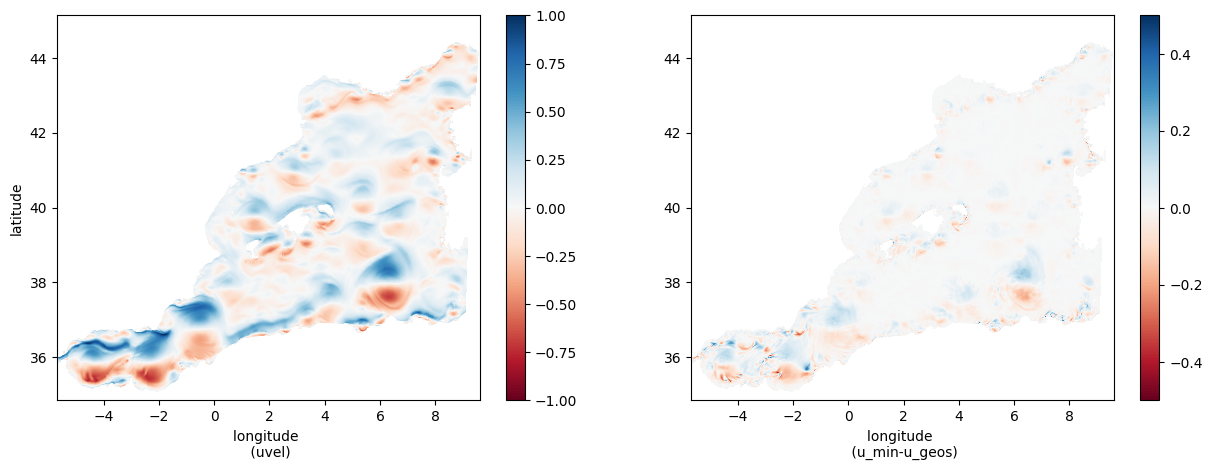

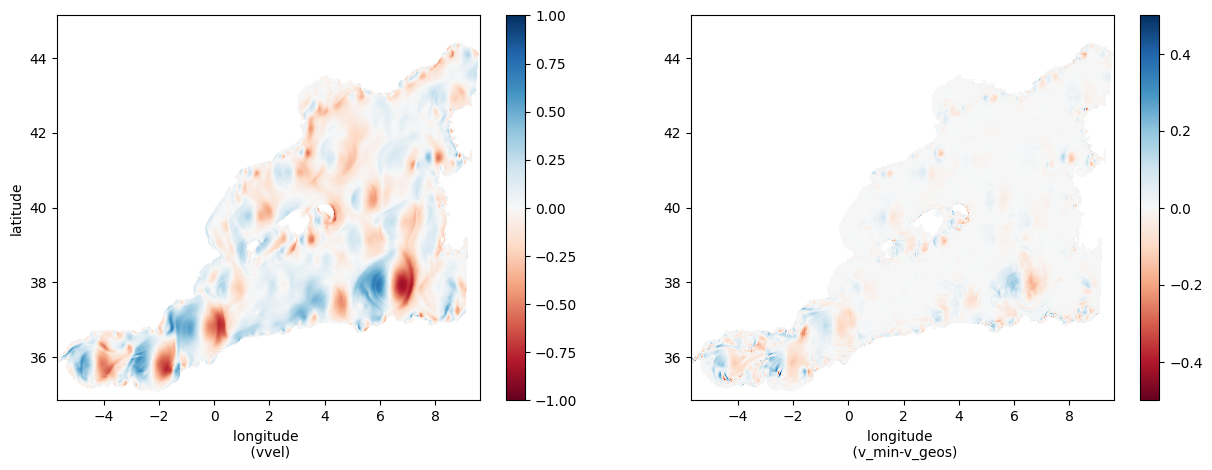

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_min-u_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_min-u_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_min-v_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_min-v_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)

## Computing the cyclogeostrophy - Iterative method

In [20]:
u_it, v_it = cyclogeostrophy(u_geos, v_geos, dx_u, dx_v, dy_u, dy_v, coriolis_factor_u, coriolis_factor_v, method="penven")

100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


In [21]:
compute_cyclogeostrophic_diff_jax(u_geos.filled(0), v_geos.filled(0), u_it.filled(0), v_it.filled(0), dx_u, dx_v, dy_u, dy_v, coriolis_factor_u.filled(1), coriolis_factor_v.filled(1))

Array(11751.554, dtype=float32)

## Plotting the iterative method

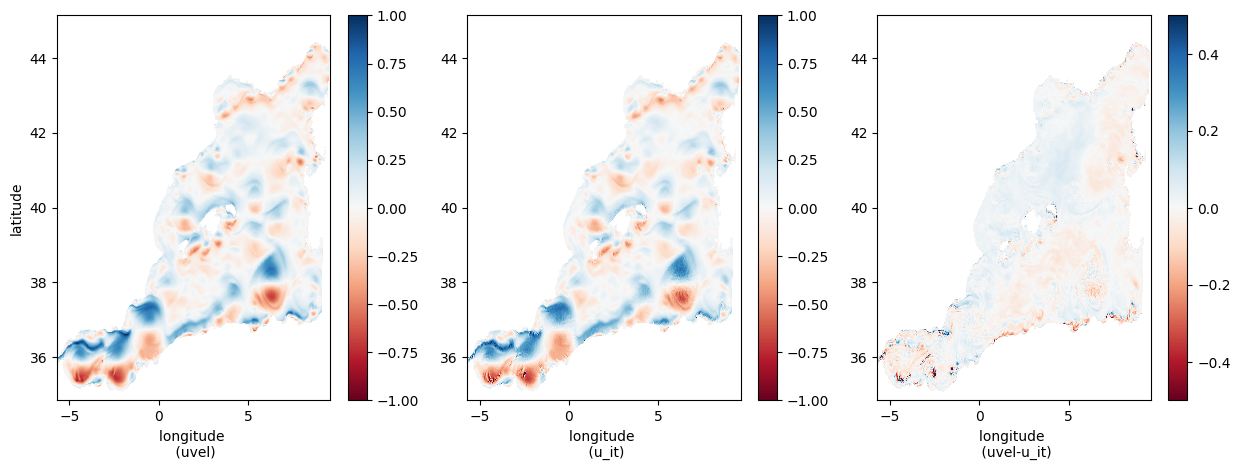

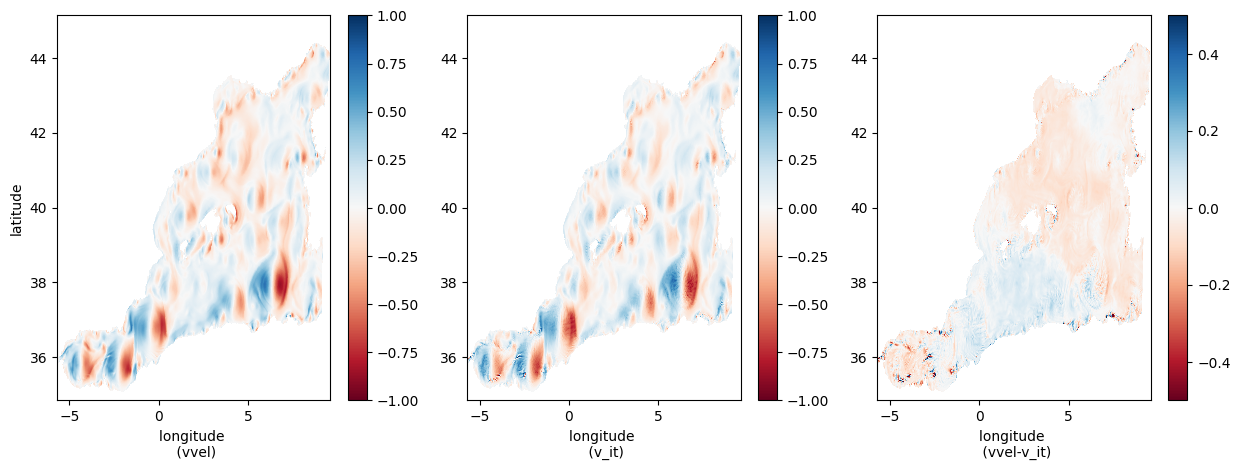

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it)")
ax3.set_xlabel("longitude \n (uvel-u_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, uvel-u_it, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it)")
ax3.set_xlabel("longitude \n (vvel-v_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax2)
im = ax3.pcolormesh(lon, lat, vvel-v_it, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax3)

## Plotting differences with the geostrophic method

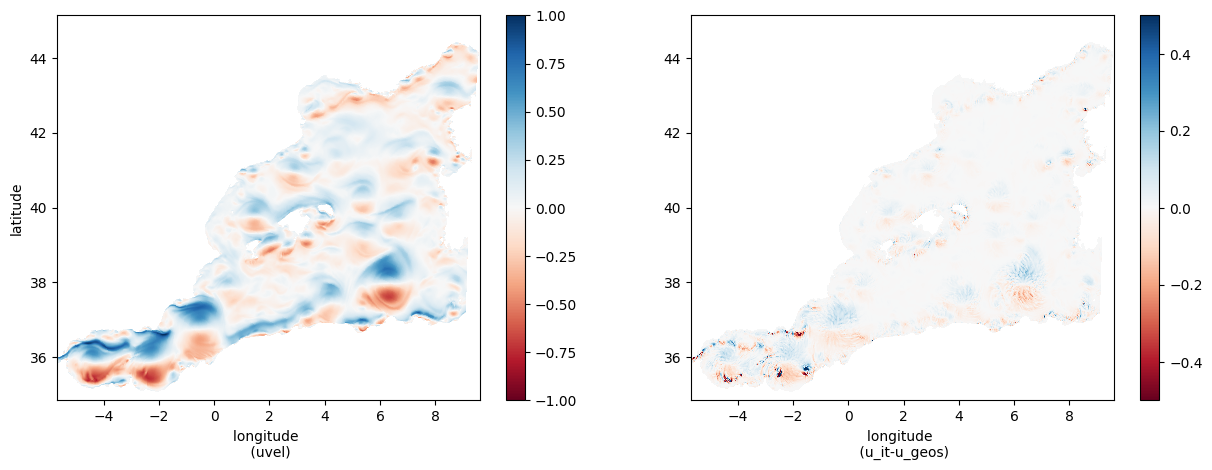

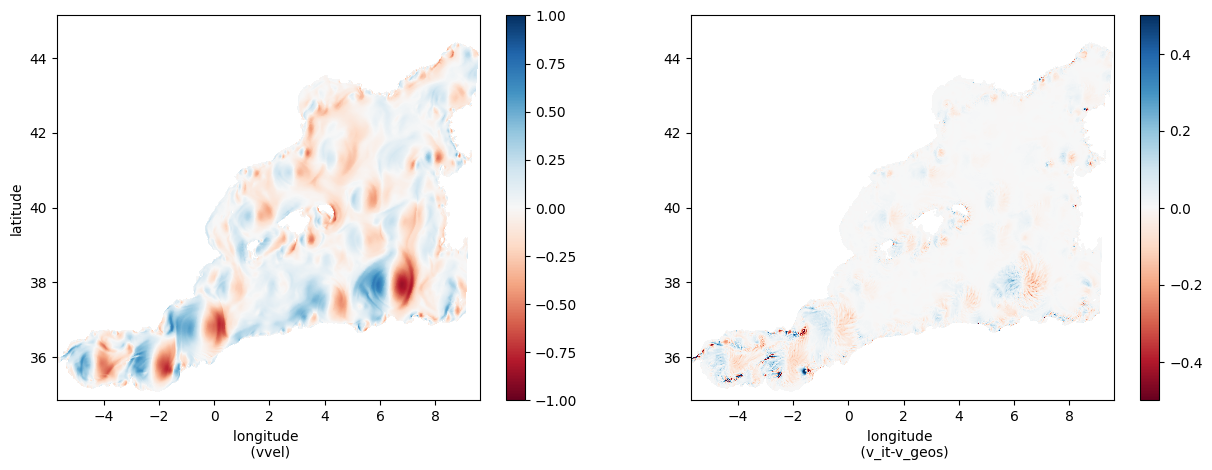

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_it-u_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_it-u_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_it-v_geos)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_it-v_geos, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)

## Plotting differences between cyclogeostrophic methods

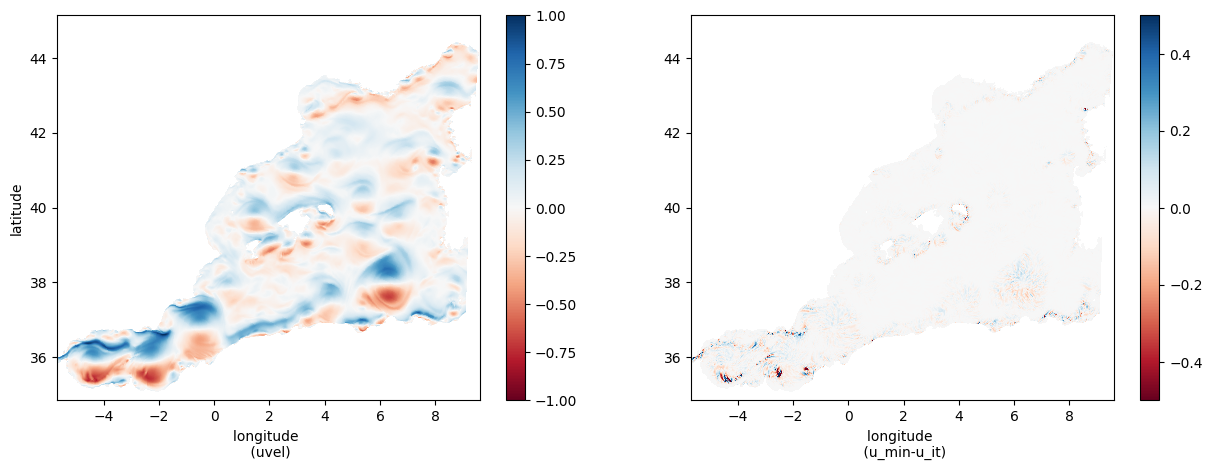

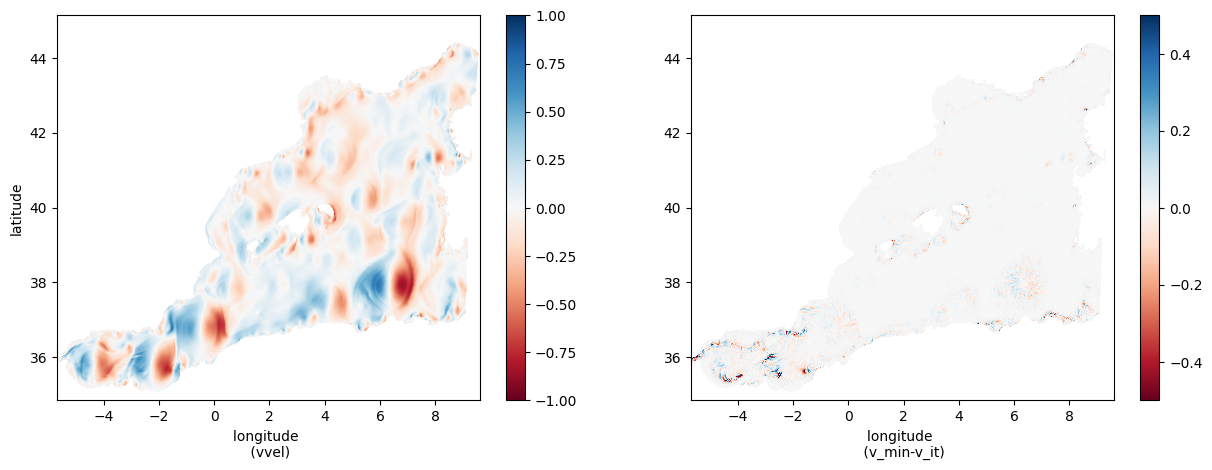

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (uvel)")
ax2.set_xlabel("longitude \n (u_min-u_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, uvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, u_min-u_it, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel("longitude \n (vvel)")
ax2.set_xlabel("longitude \n (v_min-v_it)")
ax1.set_ylabel("latitude")
im = ax1.pcolormesh(lon, lat, vvel, cmap="RdBu", shading="auto", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax1)
im = ax2.pcolormesh(lon, lat, v_min-v_it, cmap="RdBu", shading="auto", vmin=-0.5, vmax=0.5)
plt.colorbar(im, ax=ax2)